In [1]:
from pathlib import Path
import torch
from dalle_pytorch import OpenAIDiscreteVAE, VQGanVAE, DiscreteVAE, DALLE
from dalle_pytorch.tokenizer import tokenizer, HugTokenizer
import matplotlib.pyplot as plt
import torchvision
from glob import glob
import random
from PIL import Image

In [2]:
caption_files = glob("/home/soon/datasets/mannequin/captions/*")

def get_sample(i=None):
    if i is None:
        i = random.randint(0, len(caption_files))
    print("index:", i)
    caption_fname = caption_files[i]
    image_fname = caption_fname.replace('captions','images').replace('.txt','.png')
    caption = open(caption_fname).read()
    ref_image = Image.open(image_fname)    
    return caption, ref_image
    


In [3]:
DALLE_PATH = "dalle_mannequin_depth_8.pt"
CUDA = "cuda:1"
VQGAN_MODEL_PATH = "../VQGAN-CLIP/checkpoints/vqgan_imagenet_f16_16384.ckpt"
VQGAN_CONFIG_PATH = "../VQGAN-CLIP/checkpoints/vqgan_imagenet_f16_16384.yaml"
BPE_PATH = "/home/soon/github/PoseGuidedTextToImage/tokenizer-mannequin.json"


In [4]:
tokenizer = HugTokenizer(BPE_PATH)

dalle_path = Path(DALLE_PATH)
loaded_obj = torch.load(str(dalle_path), map_location='cpu')

dalle_params, vae_params, weights = loaded_obj['hparams'], loaded_obj['vae_params'], loaded_obj['weights']
opt_state = loaded_obj.get('opt_state')
#scheduler_state = loaded_obj.get('scheduler_state')
scheduler_state = None
if vae_params is not None:
    vae = DiscreteVAE(**vae_params)
else:

    #if args.taming:
    vae = VQGanVAE(VQGAN_MODEL_PATH, VQGAN_CONFIG_PATH)
    #else:
    #vae = OpenAIDiscreteVAE()

dalle_params = dict(
    **dalle_params
)
IMAGE_SIZE = vae.image_size

#if isinstance(vae, OpenAIDiscreteVAE) and args.fp16:
#    vae.enc.blocks.output.conv.use_float16 = True

dalle = DALLE(vae=vae, **dalle_params)


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from ../VQGAN-CLIP/checkpoints/vqgan_imagenet_f16_16384.ckpt and ../VQGAN-CLIP/checkpoints/vqgan_imagenet_f16_16384.yaml


In [5]:
dalle = dalle.to(CUDA)
dalle.load_state_dict(weights)

<All keys matched successfully>

In [13]:
def generate(text, filter_thres=0.9):
    tokenized_text = tokenizer.tokenize(
        text,
        128,
        truncate_text=False
    ).to(CUDA)

    image = dalle.generate_images(tokenized_text, filter_thres=filter_thres)
    image = torchvision.transforms.ToPILImage()(image.squeeze(0))
    return image

def sample(index=None):
    caption, ref_image = get_sample(index)
    new_image = generate(caption)

    f, axarr = plt.subplots(1, 2)
    f.set_figheight(5)
    f.set_figwidth(10)
    axarr[0].imshow(new_image)
    axarr[1].imshow(ref_image)
    f.suptitle(caption)
    plt.show()
    print(caption)


index: 103813


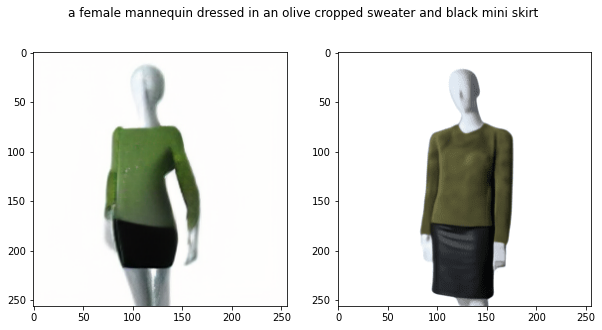

a female mannequin dressed in an olive cropped sweater and black mini skirt

index: 167823


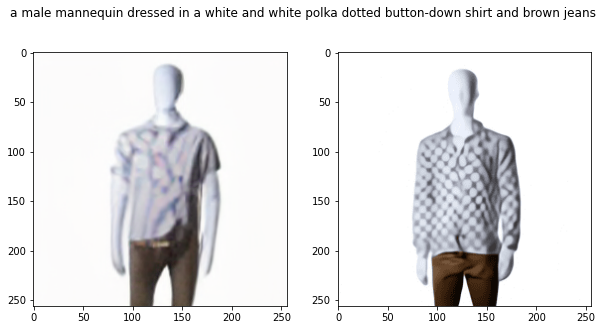

a male mannequin dressed in a white and white polka dotted button-down shirt and brown jeans

index: 101222


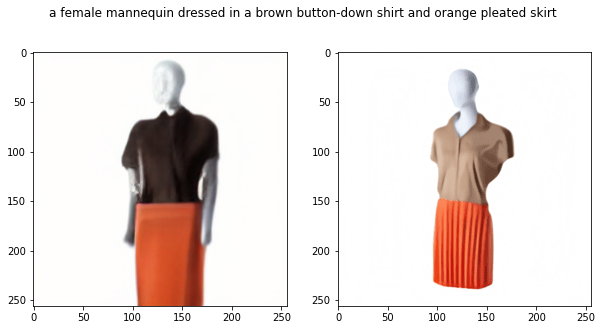

a female mannequin dressed in a brown button-down shirt and orange pleated skirt

index: 117285


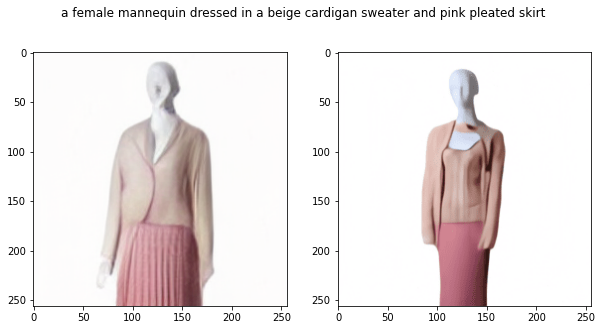

a female mannequin dressed in a beige cardigan sweater and pink pleated skirt

index: 122105


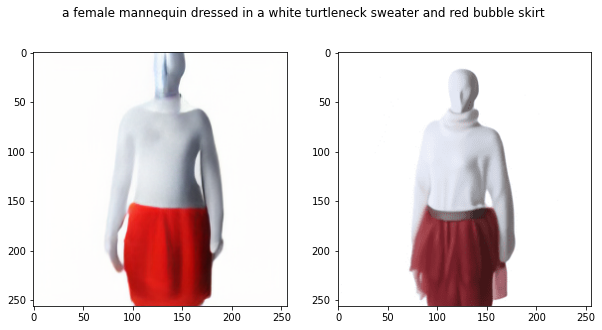

a female mannequin dressed in a white turtleneck sweater and red bubble skirt



In [24]:
for _ in range(5):
    sample()

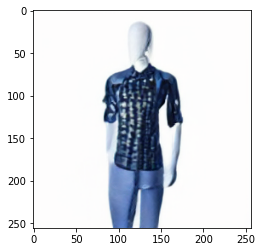

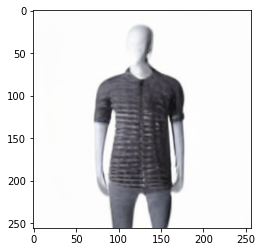

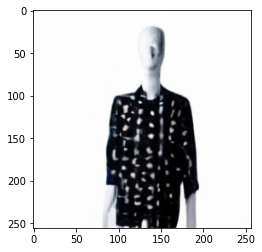

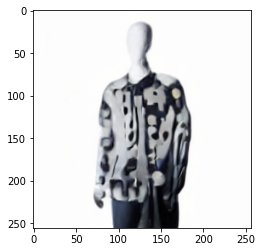

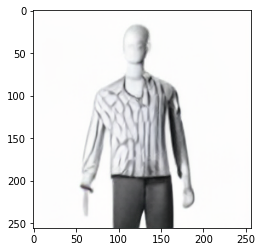

In [25]:
text = "a male mannequin dressed in an black and white polka dotted shirt"
for i in range(5):
    image = generate(text, 0.95)
    plt.imshow(image)
    plt.show()